# Flow-Aware Hillshade

This tutorial shows how to create an implementation of Joe MacGregor's 'flow-aware hillshade' (MacGregor _et al._ 2024) to interpret basal topography, using ITS_LIVE velocity data an the `pdemtools` hillshade function.

> MacGregor, J. A., Colgan, W. T., Paxman, G. J. G., Tinto, K. J., Csathó, B., Darbyshire, F. A., et al. (2024). Geologic provinces beneath the Greenland Ice Sheet constrained by geophysical data synthesis. Geophysical Research Letters, 51, e2023GL107357. https://doi.org/10.1029/2023GL107357

**__NOTE__**: This notebook requires at least v0.8.1 of `pdemtools`.

In [1]:

import os

import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from rasterio.enums import Resampling

# %matplotlib widget
%matplotlib inline

We will calculate a flow-aware hillshade for the rough region shown in figure 1b of MacGregor _et al._ (2024):

In [2]:

bounds = (-322000, -1197000, -209000, -1098000)


## Download ITS_LIVE mosaic

We can download the the ITS_LIVE multiyear velocity mosaic from the AWS-stored cloud-optimised geotiffs using `rioxarray`:

In [3]:

vx_fpath = "https://its-live-data.s3-us-west-2.amazonaws.com/velocity_mosaic/v2/static/cog/ITS_LIVE_velocity_120m_RGI05A_0000_v02_vx.tif"
vy_fpath = "https://its-live-data.s3-us-west-2.amazonaws.com/velocity_mosaic/v2/static/cog/ITS_LIVE_velocity_120m_RGI05A_0000_v02_vy.tif"

vx = rxr.open_rasterio(vx_fpath).rio.clip_box(*bounds).compute()
vy = rxr.open_rasterio(vy_fpath).rio.clip_box(*bounds).compute()

vv = np.sqrt(vx ** 2 + vy ** 2)


Let's visualise this velocity field as a test:

Text(0.5, 1.0, '')

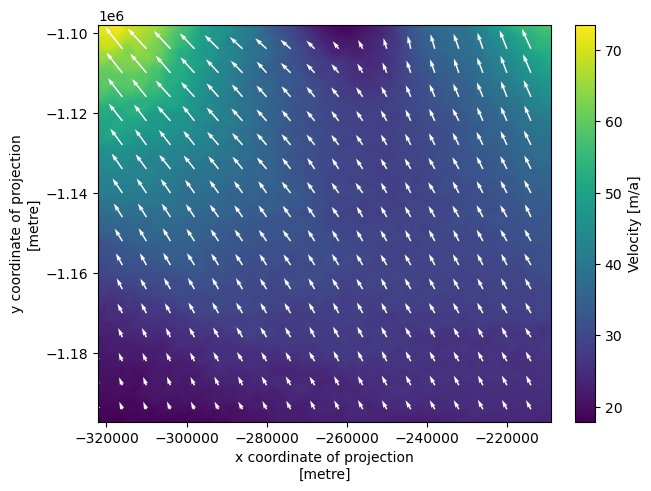

In [4]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

vv.plot(cmap='viridis', ax=ax, cbar_kwargs={'label': 'Velocity [m/a]'})

show_every = 50  # Plot the velocity as a quiver plot, showing only every 50 quivers
skip = slice(None, None, show_every)
ax.quiver(
    vx.squeeze().x.values[skip], vx.squeeze().y.values[skip], 
    vx.squeeze().values[skip, skip], vy.squeeze().values[skip, skip],
    color='w',
)

ax.set_aspect('equal')
ax.set_title(None)


## Download ArcticDEM

Next, we can download the 32 m ArcticDem mosaic using `pdemtools`.

In [5]:

%%time
dem = pdt.load.mosaic(
    dataset='arcticdem',  # must be `arcticdem` or `rema`
    resolution=32,        # must be 2, 10, or 32
    bounds=bounds,        # (xmin, ymin, xmax, ymax) or shapely geometry
    version='v4.1',       # optional: desired version (defaults to most recent)
)


CPU times: user 718 ms, sys: 154 ms, total: 872 ms
Wall time: 20.3 s


This method works best at lower resolution, so we will resample the dem to the resolution of the ITS_LIVE grid (120 m).

In [6]:

dem = dem.rio.reproject_match(vx)
dem = dem.where(dem>=0)


Let's visualise the elevation with a normal hillshade:

In [7]:

hillshade = dem.pdt.terrain('hillshade', hillshade_z_factor=2, hillshade_multidirectional=True)


Text(0.5, 1.0, '')

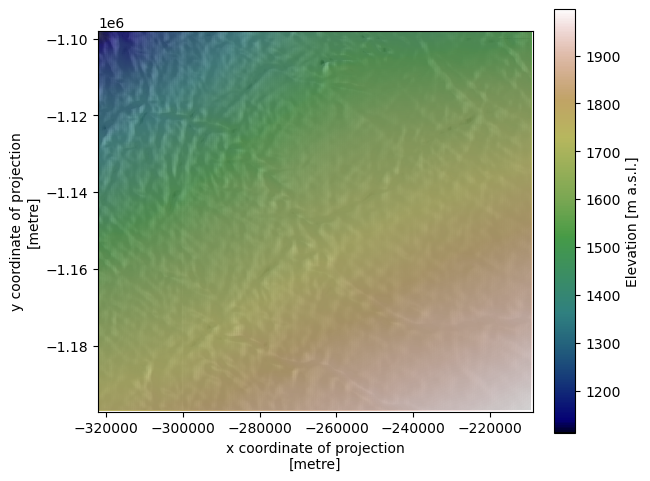

In [8]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

dem.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Elevation [m a.s.l.]'})
hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(None)


## Calculate flow aware hillshade

In low flow regions (< 100 m/a), MacGregor _et al._ calculate the flow-aware hillshade azimuth as a weighted value between the ice flow direction and the surface gradient. We can calulate both of these, starting with the flow direction. (Note: the `pdemtools` hillshade tool expects an azimuth in degrees clockwise from north, so we will work in radians where necessary but keep outputs in this format degrees).

In [9]:

def get_flow_direction(vx, vy):
    # in degrees clockwise from due north
    
    direction_rad = np.arctan2(vy, vx) 
    direction_deg = np.rad2deg(direction_rad) - 90 # subtract 90 to get from degrees clockwise from east to degrees clockwise from north
    direction_deg = 360 - direction_deg

    return direction_deg
    
flow_direction = get_flow_direction(vx, vy)


Text(0.5, 1.0, '')

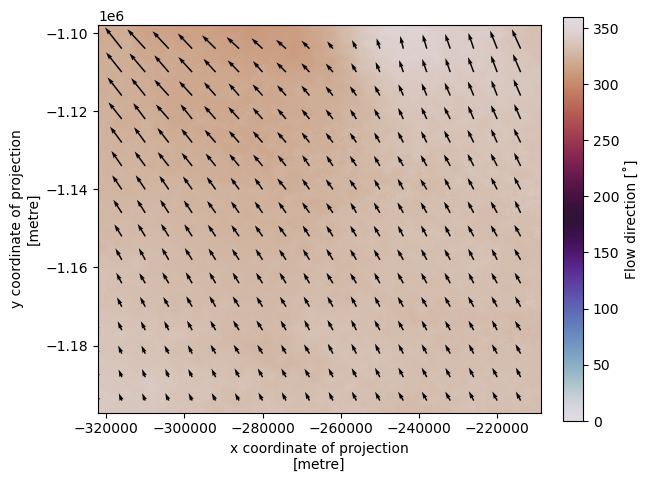

In [10]:
# Plot for assessment
plt.close()
fig, ax = plt.subplots(layout='constrained')
flow_direction.plot(cmap='twilight', vmin=0, vmax=360, cbar_kwargs={'label': 'Flow direction [˚]'})

show_every = 50  # Plot the velocity as a quiver plot, showing only every 50 quivers
skip = slice(None, None, show_every)
ax.quiver(vx.squeeze().x.values[skip], vx.squeeze().y.values[skip], vx.squeeze().values[skip, skip], vy.squeeze().values[skip, skip])#, , )

ax.set_aspect('equal')
ax.set_title(None)

Aspect is trivial to calculate with `pdemtools`:

In [11]:
aspect = dem.pdt.terrain('aspect')

Text(0.5, 1.0, '')

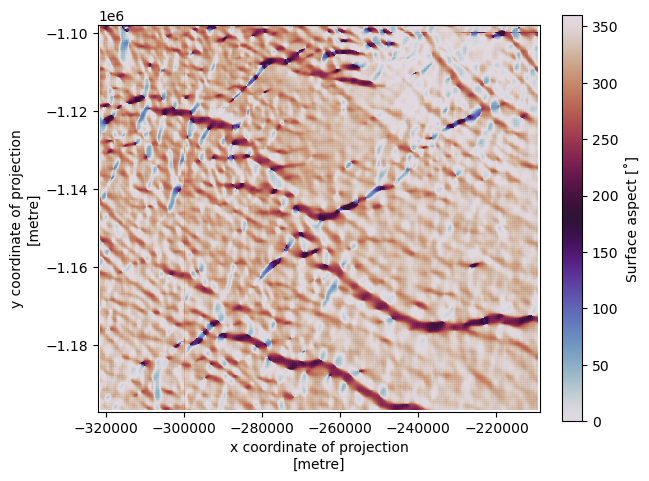

In [12]:
plt.close()
fig, ax = plt.subplots(layout='constrained')
aspect.plot(cmap='twilight', vmin=0, vmax=360, ax=ax, cbar_kwargs={'label': 'Surface aspect [˚]'})
ax.set_aspect('equal')
ax.set_title(None)

We can now calculate the weighted flow-aligned azimuth based on the original matlab script from MacGregor _et al._ 2024, [available on the GEUS dataverse](https://eur01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdataverse.geus.dk%2Ffile.xhtml%3FpersistentId%3Ddoi%3A10.22008%2FFK2%2FBUQQ9C%2FFSOLDJ%26version%3D2.1&data=05%7C02%7Cthomas.r.chudley%40durham.ac.uk%7Cebf18d7741c64cf5260b08dc7fffb032%7C7250d88b4b684529be44d59a2d8a6f94%7C0%7C0%7C638525983357476368%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=XAL%2B2LmPq%2BFQsG6p4DoEAUKyIkeBIbQDKm1tSaEJAj8%3D&reserved=0). Thanks to Joe MacGregor for assistance here!

Text(0.5, 1.0, '')

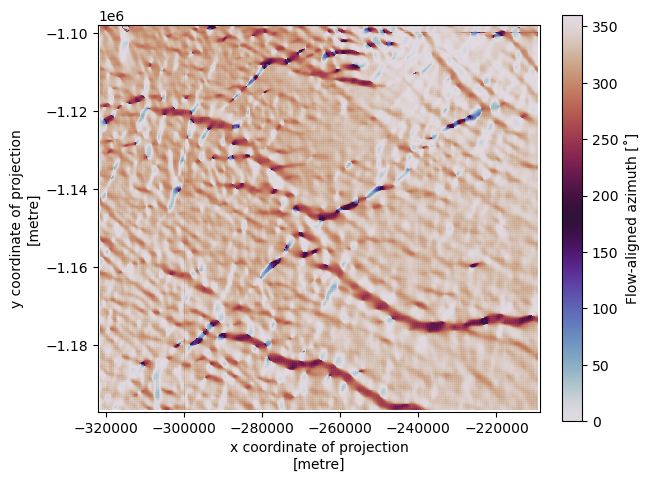

In [13]:

# convert calculated variables to radians, as 2D numpy arrays
az_speed = np.deg2rad(flow_direction.values).squeeze()
az_elev = np.deg2rad(aspect.values).squeeze()

# weight filter exponentially using reference speed
speed_az_decay = 100 # speed above which weight is unity for InSAR surface speeds, m/s (100 in GBTSv1)
speed_uncert_rel_decay = 0.25 # (0.1 in GBTSv1, 0.25 here), also fractional cutoff for speeds

# calculate relative weights of elevation and speed
wt_az_elev = np.exp(-vv.values.squeeze() / speed_az_decay) # characteristic length of surface speed to unity ratio
wt_az_elev[wt_az_elev > 1] = 1
wt_az_speed = 1 - wt_az_elev
wt_az_elev[np.isnan(az_speed)] = 1 # maximum weight (1) if the other is NaN
wt_az_speed[np.isnan(az_elev)] = 1

# calculate the weighted azimuth

az_sin_speed = np.sin(az_speed)
az_cos_speed = np.cos(az_speed)
az_sin_elev = np.sin(az_elev)
az_cos_elev = np.cos(az_elev)

az_mean = np.arctan2( 
    (az_sin_speed * wt_az_speed) + (az_sin_elev * wt_az_elev),
    (az_cos_speed * wt_az_speed) + (az_cos_elev * wt_az_elev)
)

# convert back into degrees-clockwise-from-north
azimuth_flt = np.rad2deg(az_mean) + 360
azimuth_flt = azimuth_flt % 360

# convert back into rioxarray object
azimuth_flt = flow_direction * 0 + azimuth_flt

plt.close()
fig, ax = plt.subplots(layout='constrained')
azimuth_flt.plot(cmap='twilight', ax=ax, cbar_kwargs={'label': 'Flow-aligned azimuth [˚]'}, vmin=0, vmax=360, )
ax.set_aspect('equal')
ax.set_title(None)


MacGregor _et al._ (2024) recommend that the illumination azimuth be 90˚ offset to the filtered flow direction, so that is what we calculate in this function (again, note also the we calculate the degrees-clockwise-from-north, to match the expected input of the `pdemtools` hillshade function).

Text(0.5, 1.0, '')

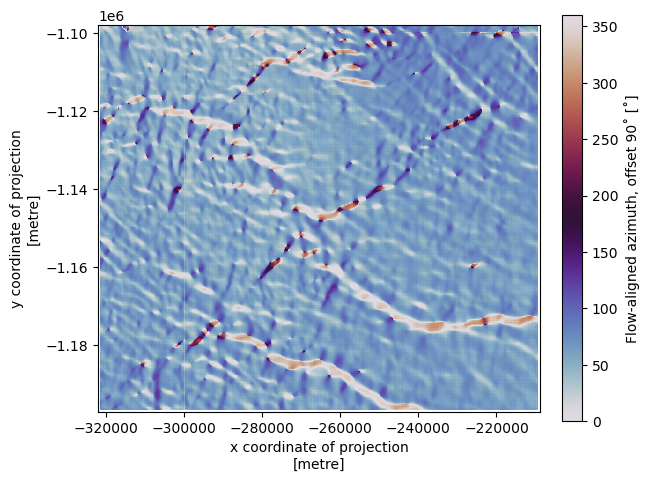

In [14]:

offset = 90  # offset from flow-aligned hillshade

final_azimuth = (azimuth_flt + offset) % 360

plt.close()
fig, ax = plt.subplots(layout='constrained')
final_azimuth.plot(cmap='twilight', ax=ax, cbar_kwargs={'label': 'Flow-aligned azimuth, offset 90˚ [˚]'}, vmin=0, vmax=360, )
ax.set_aspect('equal')
ax.set_title(None)


We can now run the `pdemtools` hillshade function, but instead of inputting a single value to our `hillshade_azimuth` variable, we feed in our calculated azimuths as a `numpy` array (by calling `.values` on the xarray DataArray). Note the relatively high `hillshade_z_factor`!

In [15]:

fa_hillshade = dem.pdt.terrain(
    'hillshade', 
    hillshade_z_factor = 100, 
    hillshade_altitude = 60,
    hillshade_azimuth = final_azimuth.values,
    hillshade_multidirectional=False,
)


Here's the final result!

Text(0.5, 1.0, 'Flow-aware hillshade (MacGregor et al. 2024)')

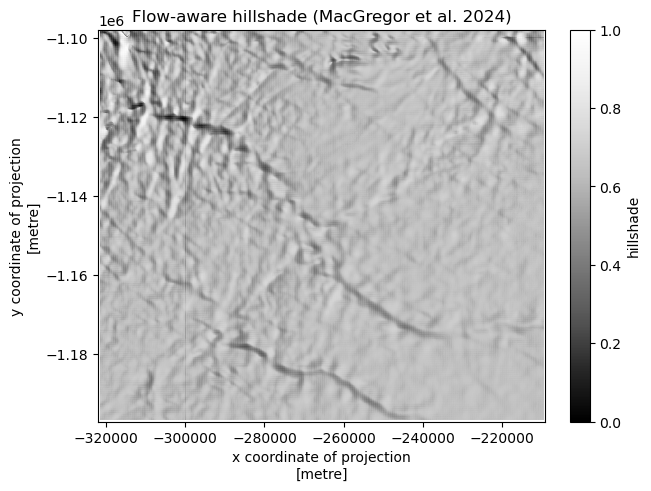

In [16]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

fa_hillshade.plot(ax=ax, cmap='Greys_r')#, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title('Flow-aware hillshade (MacGregor et al. 2024)')


## Compare with BedMachine

BedMachine doesn't have particularly good coverage in this location, but we can still check to see whether there is any identifiable bed topography that exists in the flow-aligned hillshade: 

In [17]:

bedmachine_fpath = ".../BedMachineGreenland-v5.nc"

bed = rxr.open_rasterio(f"{bedmachine_fpath}")["bed"]
bed = bed.rio.reproject_match(dem, Resampling.bilinear)

bed_hillshade =  bed.pdt.terrain('hillshade', hillshade_z_factor=2, hillshade_multidirectional=True)


Text(0.5, 1.0, 'BedMachine bed hillshade')

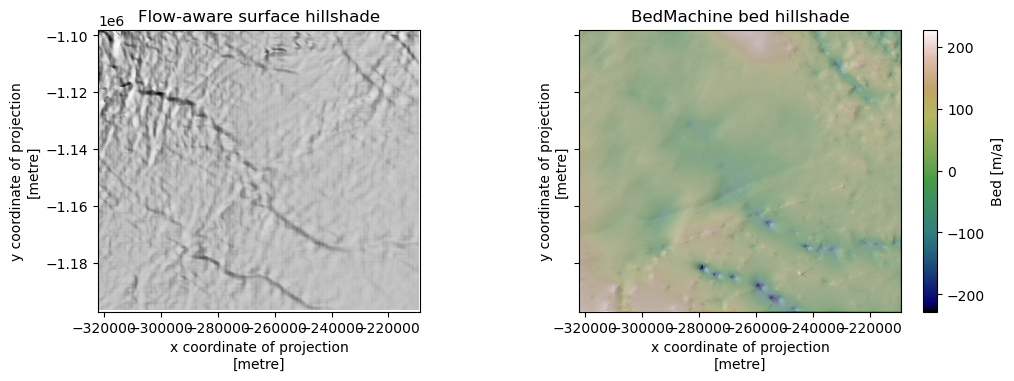

In [18]:

plt.close()
fig, axes = plt.subplots(layout='constrained', ncols=2, figsize=(10,3.7), sharex=True, sharey=True)

ax = axes[0]
fa_hillshade.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('Flow-aware surface hillshade')

ax = axes[1]
bed.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Bed [m/a]'})
bed_hillshade.plot(ax=ax, cmap='Greys_r', alpha=0.6, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('BedMachine bed hillshade')


We can indeed see reflections of the (sparse observed) basal topography in the flow-aligned hillshade!

Finally, let's save our data.

In [19]:

if not os.path.exists('example_data'):
    os.mkdir('example_data')

output_fname = 'macgregortest'

vx.rio.to_raster(os.path.join('example_data', f'{output_fname}_vx.tif'), compress='ZSTD', predictor=3, zlevel=1)
vy.rio.to_raster(os.path.join('example_data', f'{output_fname}_vy.tif'), compress='ZSTD', predictor=3, zlevel=1)
dem.rio.to_raster(os.path.join('example_data', f'{output_fname}_dem.tif'), compress='ZSTD', predictor=3, zlevel=1)
fa_hillshade.rio.to_raster(os.path.join('example_data', f'{output_fname}_floawaligndhillshade.tif'), compress='ZSTD', predictor=3, zlevel=1)
